In [30]:
import numpy
from tqdm import tqdm
import time
from scipy.stats import multinomial
from scipy import stats
import ipyparallel as ipp
from qiskit.extensions import UnitaryGate
from qiskit.aqua.operators.legacy import op_converter
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
#from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from qiskit.chemistry import FermionicOperator
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit.quantum_info import Pauli
from qiskit import QuantumCircuit,execute,QuantumRegister,execute,ClassicalRegister
from qiskit import Aer
from qiskit.providers.aer import AerSimulator
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, CircuitStateFn 
import scipy
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.compiler import transpile
from qiskit.circuit.random import random_circuit
from qiskit.chemistry.components.variational_forms import UCCSD

In [31]:
import warnings
warnings. filterwarnings('ignore')

In [32]:
c = ipp.Client()
num_qubits=8

In [33]:
v = c.load_balanced_view([1,2,3])

In [34]:
%run Utils.ipynb
%run SMO.ipynb
%run EstimateHamiltonianMean.ipynb

In [35]:
U=7
qubitH,Hmat,Eg,state_g=egBandHamiltonian(U)

In [36]:
labels_ansatz=[]
params_ansatz=[]
#ansatz construction
with open('../'+str(U)+'/QasmVsStatevector/HF_statevector_adapt_VQE.txt','r') as f:
    lines=f.readlines()[2:]
    for line in lines:
        elems=line.split()
        labels_ansatz.append(elems[1])
        params_ansatz.append(float(elems[3]))

In [37]:
#Hamiltonian grouping for circuit based measurement
eg_h1_0,eg_h1_1,eg_h2_0,eg_h2_1=egBandHamiltonianPartition(U)
qubitH_0,qubitH_1,qubitH_2=qubitHamiltonianGroups(U)
opArr=[qubitH_0,qubitH_1,qubitH_2]
#two body off diags
circ0_1gate,rotH2body=OffDiag2BodyTerms(opArr[2])
#one body off diags
circ0_8gate,rotH1body=OffDiag1BodyTerms(opArr[0])
Ops=[rotH1body,opArr[1],rotH2body]

In [38]:
backend=Aer.get_backend('statevector_simulator')
HFcirc,HFstate=HF_init_state(U)
var_form_base=UCCSD(8,4,initial_state=HFcirc,two_qubit_reduction=False,qubit_mapping='jordan_wigner')
var_form_base.manage_hopping_operators()
for i in range(len(labels_ansatz)):
        var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli.from_label(labels_ansatz[i])]]))

Final Hartree Fock Energy -18.788335371650774


In [39]:
#state_vec
circ=var_form_base.construct_circuit(parameters=params_ansatz)
state_vec=execute(circ,Aer.get_backend('statevector_simulator'),num_shots=2**10).result().get_statevector()
exactE0=state_vec@qubitH_0.to_matrix()@numpy.conjugate(state_vec)
exactE1=state_vec@qubitH_1.to_matrix()@numpy.conjugate(state_vec)
exactE2=state_vec@qubitH_2.to_matrix()@numpy.conjugate(state_vec)
exactEs=[exactE0,exactE1,exactE2]

In [40]:
tot_num_shots=2**14

In [41]:
qr=QuantumRegister(8,'q')

$C(A,B)=\langle AB\rangle -\langle A\rangle\langle B\rangle$<br>
$=\sum_{ij}\langle A_{i}B_{j}\rangle-\langle A_{i}\rangle\langle B_{j}\rangle$

In [42]:
def estimate(PauliOp,counts):
    PauliString,coeff=PauliOp.primitive.to_list()[0]
    indexOfZs=numpy.where(numpy.array(list(PauliString))=='Z')[0]
    bitstrings,cnts=list(counts. keys()),list(counts.values())
    p=0
    for i in range(len(bitstrings)):
        counter_1=list(numpy.array(list(bitstrings[i]))[indexOfZs]).count('1')
        if counter_1%2==1:
            p=p+cnts[i]
    p=p/sum(cnts)
    mean=(1-2*p)
    return mean*coeff.real
def meanOp(PauliOp,counts):
    mean=0
    for i in range(len(PauliOp)):
        mean=mean+estimate(PauliOp[i],counts)
    return mean    
def covariance(Op,i,j,counts):
    cov=estimate(Op[i]@Op[j],counts)-estimate(Op[i],counts)*estimate(Op[j],counts)
    return cov
def covbtnOps(A,B):
    corr=0
    for i in range(len(A)):
        for j in range(len(B)):
            corr=corr+estimate(A[i]@B[j],counts)-estimate(A[i],counts)*estimate(B[j],counts)
    return corr        
def variance(Op,counts):
    var=0
    cov_mat=numpy.zeros((len(Op),len(Op)))
    for i in range(len(Op)):
        for j in range(i,len(Op)):
            if i==j:
                mean=estimate(Op[i],counts)
                coeff=Op[i].primitive.to_list()[0][1].real
                cov_mat[i][j]=(coeff**2-mean**2)
                var=var+(coeff**2-mean**2)
            elif i!=j:
                var=var+2*covariance(Op,i,j,counts)
                cov_mat[i][j]=cov_mat[j][i]=covariance(Op,i,j,counts)
    return var#/num_shots
def controlVariate(Op,counts):
    #construct another operator for another U
    
    U1=2
    eg_h1_0,eg_h1_1,eg_h2_0,eg_h2_1=egBandHamiltonianPartition(U1)
    qubitH_0,qubitH_1,qubitH_2=qubitHamiltonianGroups(U1)
    opArr=[qubitH_0,qubitH_1,qubitH_2]
    #two body off diags
    circ0_1gate,rotH2body=OffDiag2BodyTerms(opArr[2])
    #one body off diags
    circ0_8gate,rotH1body=OffDiag1BodyTerms(opArr[0])
    Ops1=[rotH1body,opArr[1],rotH2body]
    ControlOp=Ops1[1]
    mean=meanOp(ControlOp,counts)
    exact1=state_vec@ControlOp.to_matrix()@numpy.conjugate(state_vec)
    cov=covbtnOps(Op,ControlOp)
    var=variance(ControlOp,counts)
    newOp=Op+((-cov/var)*(ControlOp-(exact1*I^I^I^I^I^I^I^I)))
    print("correlation coeff", cov/numpy.sqrt(variance(ControlOp,counts)*variance(Op,counts)))
    print("variance of Hamiltonian part at lower U","U=%s"%str(U1),numpy.sqrt(var/sum(counts.values())))
    m=meanOp(newOp,counts)
    var=variance(newOp,counts)
    err=numpy.sqrt(var/sum(counts.values()))
    return m,err

In [43]:
def getCounts(Input):
    circ,num_shots=Input
    from qiskit.providers.aer import AerSimulator
    from qiskit import execute
    job_sim = execute(circ, AerSimulator(method='density_matrix'), shots=num_shots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(circ) 
    return counts

In [44]:
getCounts((circ,2**14))

QiskitError: 'No counts for experiment "<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f11cb6b8ac0>"'

In [24]:
def controlVariateMean(Ops,params,num_shots_arr):
    def covbtnOps(A,B,counts):
        corr=0
        for i in range(len(A)):
            for j in range(len(B)):
                corr=corr+estimate(A[i]@B[j],counts)-estimate(A[i],counts)*estimate(B[j],counts)
        return corr  
    def construct_appended_circuits(data_arr):
        qr,backend,circ0_8gate,circ0_1gate,circ,op,i=data_arr
        circ1=circ.copy()
        if i==0:
            circ1.append(circ0_8gate,qr)
        elif i==2:
            circ1.append(circ0_1gate,[qr[0],qr[1]])
            circ1.append(circ0_1gate,[qr[4],qr[5]])
        circ1.add_register(ClassicalRegister(8,'c'))
        circ1.measure([0,1,2,3,4,5,6,7],[0,1,2,3,4,5,6,7])    
        return circ1
    def estimateHpart(Op,counts,i):
        mean,stat_err=controlVariate(Op,counts,i)
        return mean,stat_err
    def controlVariate(Op,counts,i):
        #construct another operator for another U
        U1=2
        eg_h1_0,eg_h1_1,eg_h2_0,eg_h2_1=egBandHamiltonianPartition(U1)
        qubitH_0,qubitH_1,qubitH_2=qubitHamiltonianGroups(U1)
        opArr=[qubitH_0,qubitH_1,qubitH_2]
        #two body off diags
        circ0_1gate,rotH2body=OffDiag2BodyTerms(opArr[2])
        #one body off diags
        circ0_8gate,rotH1body=OffDiag1BodyTerms(opArr[0])
        Ops1=[rotH1body,opArr[1],rotH2body]
        ControlOp=Ops1[1]
        mean=meanOp(ControlOp,counts)
        #exact1=state_vec@ControlOp.to_matrix()@numpy.conjugate(state_vec)
        cov=covbtnOps(Op,ControlOp,counts)
        var=variance(ControlOp,counts)
        newOp=Op+((-cov/var)*(ControlOp-(mean*I^I^I^I^I^I^I^I)))
        print("correlation coeff", cov/numpy.sqrt(variance(ControlOp,counts)*variance(Op,counts)))
        print("variance of Hamiltonian part at lower U","U=%s"%str(U1),numpy.sqrt(var/sum(counts.values())))
        m=meanOp(newOp,counts)
        var=variance(newOp,counts)
        err=numpy.sqrt(var/sum(counts.values()))
        return m,err
    backend = AerSimulator(method='density_matrix')
    qc=var_form_base.construct_circuit(parameters=params)
    data_arr=[(qr,backend,circ0_8gate,circ0_1gate,qc,Ops[i],i) for i in range(len(Ops))]
    inp_data=[(construct_appended_circuits(data_arr[i]),num_shots_arr[i]) for i in range(len(data_arr))]
    result = v.map_async(getCounts, inp_data)
    result=result.get()
    meanAndError=[estimateHpart(Ops[i],result[i],i) for i in range(len(Ops))]
    netMean=meanAndError[0][0]+meanAndError[1][0]+meanAndError[2][0]
    netErr=meanAndError[0][1]+meanAndError[1][1]+meanAndError[2][1]
    indMeans=meanAndError[0][0],meanAndError[1][0],meanAndError[2][0]
    indErrs=meanAndError[0][1],meanAndError[1][1],meanAndError[2][1]
    return netMean,netErr,indMeans,indErrs
def directMean(Ops,params_ansatz,num_shots):
    num_shots=tot_num_shots
    data=HamiltonianEstm(Ops,params_ansatz,[num_shots,num_shots,num_shots])#s[1][1:],params_ansatz,1)#Ops[1][1:]
    return data

In [29]:
err_dir=[]
for i in tqdm(range(10)):
    num_shots=2**17
    data0=controlVariateMean(Ops,params_ansatz,[num_shots,num_shots,num_shots])
    data1=directMean(Ops,params_ansatz,num_shots)
    print(numpy.abs(data0[0]-sum(exactEs)),numpy.abs(data1[0]-sum(exactEs)))

  0%|          | 0/10 [00:00<?, ?it/s]

correlation coeff 0.39356131006629097
variance of Hamiltonian part at lower U U=2 0.0025563209771703307
correlation coeff 0.9805863511047651
variance of Hamiltonian part at lower U U=2 0.0006116855790463306
correlation coeff -0.6728519105924068
variance of Hamiltonian part at lower U U=2 0.0006219130450970623


 10%|█         | 1/10 [00:12<01:48, 12.09s/it]

0.003193159895570119 0.0045104662006956175
correlation coeff 0.39281249570036947
variance of Hamiltonian part at lower U U=2 0.002553148613741246
correlation coeff 0.9805788749131717
variance of Hamiltonian part at lower U U=2 0.000612483032657977
correlation coeff -0.6778038816626574
variance of Hamiltonian part at lower U U=2 0.0006233160821891707


 20%|██        | 2/10 [00:24<01:36, 12.08s/it]

0.0018661818771690264 0.0020473454027012394
correlation coeff 0.39130273525286785
variance of Hamiltonian part at lower U U=2 0.002545019794996544
correlation coeff 0.9813480902919747
variance of Hamiltonian part at lower U U=2 0.0006233665139283682
correlation coeff -0.6909357292865962
variance of Hamiltonian part at lower U U=2 0.0006159622991622128


 30%|███       | 3/10 [00:36<01:24, 12.09s/it]

0.00044502251813582916 0.001450409394969654
correlation coeff 0.3949769984819426
variance of Hamiltonian part at lower U U=2 0.0025606803486923732
correlation coeff 0.9805667731989514
variance of Hamiltonian part at lower U U=2 0.0006096021356692404
correlation coeff -0.6949604198030311
variance of Hamiltonian part at lower U U=2 0.000619326055764736


 40%|████      | 4/10 [00:48<01:12, 12.12s/it]

0.005264188805092829 0.0007166283232535875
correlation coeff 0.39345210931739827
variance of Hamiltonian part at lower U U=2 0.002537296591453144
correlation coeff 0.981642000016886
variance of Hamiltonian part at lower U U=2 0.000626552515175369
correlation coeff -0.6584292948047542
variance of Hamiltonian part at lower U U=2 0.0006273067391610512


 50%|█████     | 5/10 [01:00<01:00, 12.02s/it]

0.0011918367220502546 0.007457784493396957
correlation coeff 0.3940569199385977
variance of Hamiltonian part at lower U U=2 0.0025608418767472806
correlation coeff 0.9809038352894077
variance of Hamiltonian part at lower U U=2 0.0006146116070117834
correlation coeff -0.6859639810593381
variance of Hamiltonian part at lower U U=2 0.0006176321548145273


 60%|██████    | 6/10 [01:13<00:49, 12.32s/it]

0.0031959238413854507 0.0024751149906130365
correlation coeff 0.3949213813377709
variance of Hamiltonian part at lower U U=2 0.0025504625321681007
correlation coeff 0.9810865707743208
variance of Hamiltonian part at lower U U=2 0.0006173092474400432
correlation coeff -0.6849940898992847
variance of Hamiltonian part at lower U U=2 0.0006223520613888947


 70%|███████   | 7/10 [01:25<00:36, 12.28s/it]

0.003650294355761474 0.005066658210871822
correlation coeff 0.39383464309264465
variance of Hamiltonian part at lower U U=2 0.0025498058076045553
correlation coeff 0.9814537575407053
variance of Hamiltonian part at lower U U=2 0.0006252582251958722
correlation coeff -0.6844255116424546
variance of Hamiltonian part at lower U U=2 0.000619564395325343


 80%|████████  | 8/10 [01:38<00:24, 12.43s/it]

0.0005072200142919314 0.004663588126454954
correlation coeff 0.39796577684029627
variance of Hamiltonian part at lower U U=2 0.0025510213450904004
correlation coeff 0.9808838953777989
variance of Hamiltonian part at lower U U=2 0.0006158703019502235
correlation coeff -0.6766032910873249
variance of Hamiltonian part at lower U U=2 0.0006195866195683198


 90%|█████████ | 9/10 [01:50<00:12, 12.43s/it]

0.002476427052485519 0.0029607963562519046
correlation coeff 0.39586277655661223
variance of Hamiltonian part at lower U U=2 0.0025429043202365807
correlation coeff 0.9808023291435496
variance of Hamiltonian part at lower U U=2 0.00061313974191622
correlation coeff -0.6687899241308065
variance of Hamiltonian part at lower U U=2 0.0006218212439959009


100%|██████████| 10/10 [02:03<00:00, 12.34s/it]

0.003288393368990228 0.001570999059136824


In [217]:
abs_err_1_0=[err_dir[i][0] for i in range(len(err_dir))]
abs_err_1_1=[err_dir[i][1] for i in range(len(err_dir))]

# abs_err_2=[err_dir[i][1] for i in range(len(err_dir))]
mean0, var0, std0 = stats.bayes_mvs(abs_err_1_0)
mean1, var1, std1 = stats.bayes_mvs(abs_err_1_1)
print(mean0.statistic-exactE1,mean1.statistic-exactE1)

(0.0004772667433599054+0j) (0.00018426703805474176+0j)


In [106]:
import matplotlib.pyplot as plt
plt.plot([numpy.abs(res_direct[i][0]) for i in range(len(res_direct))])
plt.plot([numpy.abs(res_control_variate[i][0]) for i in range(len(res_control_variate))])

NameError: name 'res_direct' is not defined

In [131]:
HamiltonianEstm(params_ansatz)

(-19.183671501059987,
 0.0017897080204157601,
 array([0.0009217+0.j, 0.00035  +0.j, 0.000518 +0.j]),
 array([ 3.84810781, 27.39707375,  9.26883245]))

In [19]:
mean=0
var=0
for i in tqdm(range(len(coeffs))):
    num_shots=shots_dist[i]
    data=OpEstm(Ops[1][1:][i],params_ansatz,1)
    mean=mean+data[0].real
    var=var+data[1].real
var=var*len(coeffs)/numpy.sum(shots_dist)
Error=numpy.sqrt(var)

  7%|▋         | 1/14 [00:00<00:07,  1.65it/s]

time elapsed 0.6069313000043621


 14%|█▍        | 2/14 [00:01<00:07,  1.56it/s]

time elapsed 0.7221390999911819


 21%|██▏       | 3/14 [00:01<00:06,  1.58it/s]

time elapsed 0.6023944999906234


 29%|██▊       | 4/14 [00:02<00:06,  1.60it/s]

time elapsed 0.612974599993322


 36%|███▌      | 5/14 [00:03<00:06,  1.49it/s]

time elapsed 0.7765639999997802


 43%|████▎     | 6/14 [00:04<00:05,  1.47it/s]

time elapsed 0.6926787000120385


 50%|█████     | 7/14 [00:04<00:05,  1.35it/s]

time elapsed 0.8837872000003699


 57%|█████▋    | 8/14 [00:05<00:04,  1.33it/s]

time elapsed 0.7688813999993727


 64%|██████▍   | 9/14 [00:06<00:03,  1.31it/s]

time elapsed 0.7854439000075217


 71%|███████▏  | 10/14 [00:07<00:03,  1.25it/s]

time elapsed 0.893162399996072


 79%|███████▊  | 11/14 [00:08<00:02,  1.29it/s]

time elapsed 0.7143728999944869


 86%|████████▌ | 12/14 [00:08<00:01,  1.34it/s]

time elapsed 0.6676713000051677


 93%|█████████▎| 13/14 [00:09<00:00,  1.25it/s]

time elapsed 0.9166122999886284


100%|██████████| 14/14 [00:10<00:00,  1.35it/s]

time elapsed 0.7132996000000276


In [20]:
Error,mean

(0.06465016128846443, -4.940958430917808)

In [97]:
num_shots_testing_arr=[2**14,2**15,2**16,2**17,2**18,2**19,2**20,2**21,2**22,2**23,2**24,2**25]

In [39]:
mean1=[]
var1=[]
indMSE1=[]
indTimes1=[]
for i in range(len(num_shots_testing_arr)):
    num_shots=num_shots_testing_arr[i]
    data=HamiltonianEstm(params_ansatz)
    mean1.append(data[0])
    var1.append(data[1])
    indMSE1.append(data[2])
    indTimes1.append(data[3])
indMSE1=numpy.array(indMSE1)
indTimes1=numpy.array(indTimes1)

1.8929163000000244
1.036068699999987
1.1188658000000942
1.417182000000139
1.5957482000001164
2.3762162000000444
4.033278000000109
7.621471299999939
15.699479699999983
29.59431500000005
69.53502920000005
213.2024464000001


In [76]:
indMSE[:,0

array([3.66704203e-03+0.j, 2.58926124e-03+0.j, 1.83037686e-03+0.j,
       1.29635856e-03+0.j, 9.22238508e-04+0.j, 6.51751064e-04+0.j,
       4.59713965e-04+0.j, 3.25417114e-04+0.j, 2.29793656e-04+0.j,
       1.62574912e-04+0.j, 1.14988421e-04+0.j, 8.12912754e-05+0.j])

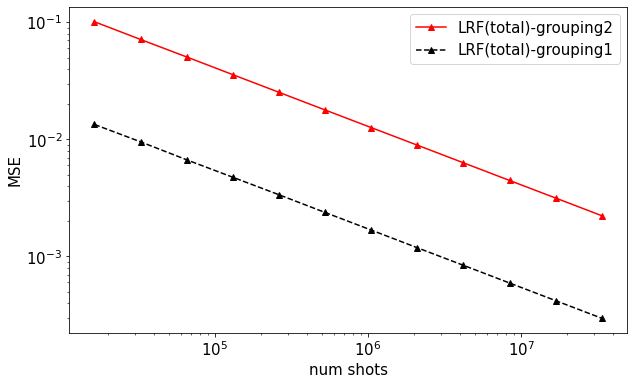

In [46]:
import matplotlib.pyplot as plt
figure,ax=plt.subplots(1,figsize=(10,6))
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize=15)
ax.set_ylabel('MSE',fontsize=15)
ax.set_xlabel('num shots',fontsize=15)
ax.plot(num_shots_testing_arr,indMSE[:,2]+indMSE[:,1]+indMSE[:,0],marker='^',color='red',linestyle='-',label='LRF(total)-grouping2')
ax.plot(num_shots_testing_arr,indMSE1[:,2]+indMSE1[:,1]+indMSE1[:,0],marker='^',color='k',linestyle='--',label='LRF(total)-grouping1')

ax.legend(fontsize=15)
plt.savefig('MSEvsShots(groupingCompare).png')

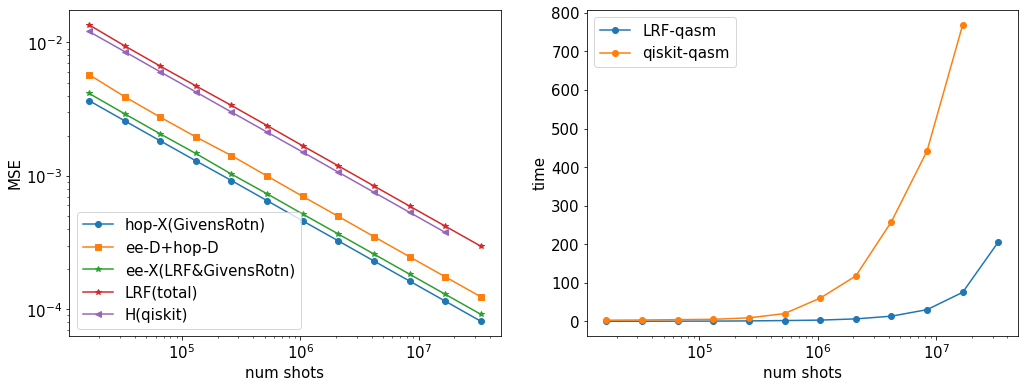

In [104]:
import matplotlib.pyplot as plt
figure,ax=plt.subplots(1,2,figsize=(17,6))
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)
ax[0].set_ylabel('MSE',fontsize=15)
ax[0].set_xlabel('num shots',fontsize=15)
ax[1].set_ylabel('time',fontsize=15)
ax[1].set_xlabel('num shots',fontsize=15)

ax[0].plot(num_shots_testing_arr,indMSE[:,0],marker='o',linestyle='-',label='hop-X(GivensRotn)')
ax[0].plot(num_shots_testing_arr,indMSE[:,1],marker='s',linestyle='-',label='ee-D+hop-D')
ax[0].plot(num_shots_testing_arr,indMSE[:,2],marker='*',linestyle='-',label='ee-X(LRF&GivensRotn)')
ax[0].plot(num_shots_testing_arr,indMSE[:,2]+indMSE[:,1]+indMSE[:,0],marker='*',linestyle='-',label='LRF(total)')
ax[0].plot(num_shots_testing_arr[:-1],MSE_arr,marker='<',linestyle='-',label='H(qiskit)')
ax[0].legend(fontsize=15)
ax[1].plot(num_shots_testing_arr,numpy.mean(indTimes,axis=1),marker='o',linestyle='-',label='LRF-qasm')
ax[1].plot(num_shots_testing_arr[:-1],Times,marker='o',linestyle='-',label='qiskit-qasm')
ax[0].legend(fontsize=15,loc='lower left')
ax[1].legend(fontsize=15)
plt.savefig('MSEvsShots.png')

In [46]:
HamiltonianEstm(params_ansatz)

(-19.18602403367829, 0.0017882909132316894)

In [84]:
mean=[]
MSE_arr=[]
Times=[]
for i in range(len(num_shots_testing_arr)):
    num_shots=num_shots_testing_arr[i]
    data=directHamMeasure(params_ansatz)
    mean.append(data[0])
    MSE_arr.append(data[1])
    Times.append(data[2])

3.2922777000003407
3.7387079999998605
4.6861862999999175
5.509184200000163
9.24479220000012
20.43827229999988
60.43811880000021
117.86294230000021
258.68373010000005
442.04382160000023
768.9701021999999


Exception ignored in: <function _releaseLock at 0x7faf08f6dee0>
Traceback (most recent call last):
  File "/home/amukh/Anaconda3-Linux/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [47]:
params=[0]*len(labels_ansatz)
max_runs=20
tol=1e-4
res=SMO_optimize_qasm(HamiltonianEstm,params,max_runs,tol)

looped 1 times
result -18.78754572359631
-18.912458602077447 0.001772434868131369 -18.912875429425355 53.295535199999904


KeyboardInterrupt: 